In [1]:
import gc
import os

import numpy as np

In [2]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager

print("l5kit version:", l5kit.__version__)

l5kit version: 1.1.0


In [3]:
os.environ["L5KIT_DATA_FOLDER"] = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"

In [4]:
import time
from datetime import datetime

In [5]:
# helper to convert a timedelta to a string (dropping milliseconds)
def deltaToString(delta):
    timeObj = time.gmtime(delta.total_seconds())
    return time.strftime('%H:%M:%S', timeObj)

class ProgressBar:
    
    # constructor
    #   maxIterations: maximum number of iterations
    def __init__(self, maxIterations):
        self.maxIterations = maxIterations
        self.granularity = 100 # 1 whole percent
    
    # start the timer
    def start(self):
        self.start = datetime.now()
    
    # check the progress of the current iteration
    #   # currentIteration: the current iteration we are on
    def check(self, currentIteration, chunked=False):
        updateIteration = round(self.maxIterations / self.granularity)
        if updateIteration == 0 or currentIteration % updateIteration == 0 or chunked:
            
            percentage = round(currentIteration / (self.maxIterations - self.maxIterations / self.granularity) * 100)
            
            current = datetime.now()
            
            # time calculations
            timeElapsed = (current - self.start)
            timePerStep = timeElapsed / (currentIteration + 1)
            totalEstimatedTime = timePerStep * self.maxIterations
            timeRemaining = totalEstimatedTime - timeElapsed
            
            # string formatting
            percentageStr = "{:>3}%  ".format(percentage)
            remainingStr = "Remaining: {}  ".format(deltaToString(timeRemaining))
            elapsedStr = "Elapsed: {}  ".format(deltaToString(timeElapsed))
            totalStr = "Total: {}\r".format(deltaToString(totalEstimatedTime))
            
            print(percentageStr + remainingStr + elapsedStr + totalStr, end="")

    def end(self):
        print()

In [6]:
dm = LocalDataManager()
dataset_path = dm.require('scenes/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
print(zarr_dataset.agents)
print(zarr_dataset.agents.shape)
n = zarr_dataset.agents.shape

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only>
(1893736,)


In [8]:
subsetPercent = 5*10**-2
print("subsetPercent", subsetPercent)
scenesLen = round(len(zarr_dataset.scenes) * subsetPercent)
print("scenesLen",scenesLen)

framesIntervalIndex = 0
agentsIntervalIndex = 1

pb0 = ProgressBar(scenesLen)
pb0.start()

totalDataCount = 0
totalAgentsCount = 0
# TODO: could possibly be faster if we get a bigger subset than currently needed and cache it for when we actually do need it

trainingAgentsDict = {}

scenesSubsetDataset = zarr_dataset.scenes[0:scenesLen]
for sceneIndex in range(0, scenesLen):
    pb0.check(sceneIndex)
    scene = scenesSubsetDataset[sceneIndex]

    framesInterval = scene[framesIntervalIndex]

    frameStart = framesInterval[0]
    frameEnd = framesInterval[1]
    
    framesSubsetDataset = zarr_dataset.frames[frameStart:frameEnd]
    for frameIndex in range(0, len(framesSubsetDataset)):
        frame = framesSubsetDataset[frameIndex]
        
        agentsInterval = frame[agentsIntervalIndex]
        
        agentStart = agentsInterval[0]
        agentEnd = agentsInterval[1]
        
        agentsSubsetDataset = zarr_dataset.agents[agentStart:agentEnd]
        for agentIndex in range(0, len(agentsSubsetDataset)):
            agent = agentsSubsetDataset[agentIndex]
            
            centroid = agent[0]
            yaw = agent[2]
            velocity = agent[3]
            track_id = agent[4]

            data = []
            data.append(centroid[0])
            data.append(centroid[1])
            data.append(yaw)
            data.append(velocity[0])
            data.append(velocity[1])
            
            if track_id not in trainingAgentsDict:
                trainingAgentsDict[track_id] = {}
            
            trainingAgentDict = trainingAgentsDict[track_id]
            
            if sceneIndex not in trainingAgentDict:
                trainingAgentDict[sceneIndex] = []
                
            trainingAgentScene = trainingAgentDict[sceneIndex]
            
            trainingAgentScene.append(data)
            totalDataCount += 1
        totalAgentsCount += 1

subsetPercent 0.05
scenesLen 5


In [9]:
print("totalDataCount",totalDataCount)
print("totalAgentsCount",totalAgentsCount)

totalDataCount 55732
totalAgentsCount 1244


In [10]:
print(len(trainingAgentsDict))
print(len(trainingAgentsDict[1]))
print(len(trainingAgentsDict[1][0]))

1998
5
17


In [11]:
import matplotlib.pyplot as plt
import random

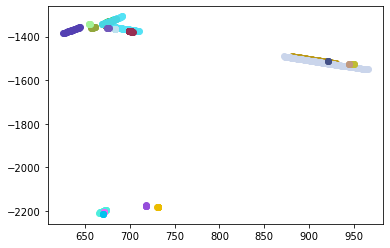

In [12]:
r = lambda: random.randint(0,255)

for i in range(1,6):
    for j in range(0,5):
        centroid_x = []
        centroid_y = []
        for data in trainingAgentsDict[i][j]:
            centroid_x.append(data[0])
            centroid_y.append(data[1])
        plt.plot(centroid_x, centroid_y, 'o', color='#%02X%02X%02X' % (r(),r(),r()))

In [13]:
dataForNormalization = []
for i in range(0, len(trainingAgentsDict[1][0][0])):
    dataForNormalization.append([])
print(len(dataForNormalization))

5


In [14]:
for track_id in trainingAgentsDict:
    scenes = trainingAgentsDict[track_id]
    for sceneIndex in scenes:
        sceneData = scenes[sceneIndex]
        for data in sceneData:
            for i in range(0, len(data)):
                feature = data[i]
                dataForNormalization[i].append(feature)

In [15]:
for i in range(0, len(dataForNormalization)):
    data = dataForNormalization[i]
    
    min_ = np.min(data)
    max_ = np.max(data)
    print("max[{}]".format(i),max_)
    print("min[{}]".format(i),min_,"\n")
    
    for track_id in trainingAgentsDict:
        scenes = trainingAgentsDict[track_id]
        for sceneIndex in scenes:
            sceneData = scenes[sceneIndex]
            for data in sceneData:
                feature = data[i]
                normalizedFeature = (feature - min_) / (max_ - min_)
                data[i] = normalizedFeature

max[0] 980.1959838867188
min[0] 593.2880859375 

max[1] -1267.021484375
min[1] -2217.884521484375 

max[2] 3.1406064
min[2] -3.1346445 

max[3] 19.079967
min[3] -17.11709 

max[4] 24.897398
min[4] -22.41946 



In [16]:
print(trainingAgentsDict[1][0][0])

[0.18543471240944495, 0.010908315970149445, 0.6615384, 0.4728862, 0.4738155]


In [17]:
historyLimit = 10

In [18]:
trainingAgentsOverLimitCount = 0
trainingAgentsDictOverLimit = {}
for track_id in trainingAgentsDict:
    scenes = trainingAgentsDict[track_id]
    for sceneIndex in scenes:
        sceneData = scenes[sceneIndex]
        if len(sceneData) > historyLimit:
            trainingAgentsOverLimitCount += 1
            
            if track_id not in trainingAgentsDictOverLimit:
                trainingAgentsDictOverLimit[track_id] = {}
            
            trainingAgentsDictOverLimit[track_id][sceneIndex] = sceneData

In [19]:
print("trainingAgentsOverLimitCount",trainingAgentsOverLimitCount)
print("totalDataCount",totalDataCount)

trainingAgentsOverLimitCount 1177
totalDataCount 55732


In [20]:
allTrainingSetsCount = 0

allTrainingSets = {}
for track_id in trainingAgentsDictOverLimit:
    scenes = trainingAgentsDictOverLimit[track_id]
    
    if track_id not in allTrainingSets:
        allTrainingSets[track_id] = {}
        
    for sceneIndex in scenes:
        sceneData = scenes[sceneIndex]
        
        if sceneIndex not in allTrainingSets[track_id]:
            allTrainingSets[track_id][sceneIndex] = []

        for i in range(0, len(sceneData) - historyLimit - 1):
            trainingSet = []
            
            start = i
            end = start + historyLimit
            output = end + 1
            
            trainingSet.append(sceneData[start:end])
            trainingSet.append(sceneData[output])
            allTrainingSets[track_id][sceneIndex].append(trainingSet)
            
            allTrainingSetsCount += 1

In [21]:
print("allTrainingSetsCount",allTrainingSetsCount)

allTrainingSetsCount 30370


In [22]:
track_idCount = len(allTrainingSets)
scenesCount = len(allTrainingSets[1])
trainingSetsCount = len(allTrainingSets[1][0])
trainingSetLength = len(allTrainingSets[1][0][0])
trainingSetInputLength = len(allTrainingSets[1][0][0][0])
inputFeaturesLength = len(allTrainingSets[1][0][0][0][0])
outputFeaturesLength = len(allTrainingSets[1][0][0][1])

print("track_idCount",track_idCount)
print("scenesCount",scenesCount)
print("trainingSetsCount",trainingSetsCount)
print("trainingSetLength",trainingSetLength)
print("trainingSetInputLength",trainingSetInputLength)
print("inputFeaturesLength",inputFeaturesLength)
print("outputFeaturesLength",outputFeaturesLength)

track_idCount 863
scenesCount 5
trainingSetsCount 6
trainingSetLength 2
trainingSetInputLength 10
inputFeaturesLength 5
outputFeaturesLength 5


In [23]:
allTrainingSetsFlattened_X = np.empty((allTrainingSetsCount, trainingSetInputLength, inputFeaturesLength))
allTrainingSetsFlattened_Y = np.empty((allTrainingSetsCount, outputFeaturesLength))

In [24]:
allTrainingSetsFlattenedCount = 0
for track_id in allTrainingSets:
    scenes = allTrainingSets[track_id]
    for trainingSetsIndex in scenes:
        trainingSets = scenes[trainingSetsIndex]
        for i in range(0, len(trainingSets)):
            trainingSet = trainingSets[i]
            allTrainingSetsFlattened_X[allTrainingSetsFlattenedCount] = trainingSet[0]
            allTrainingSetsFlattened_Y[allTrainingSetsFlattenedCount] = trainingSet[1]
            
            allTrainingSetsFlattenedCount += 1

In [25]:
print("allTrainingSetsCount",allTrainingSetsCount)
print("allTrainingSetsFlattenedCount", allTrainingSetsFlattenedCount)

allTrainingSetsCount 30370
allTrainingSetsFlattenedCount 30370


In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [27]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(trainingSetInputLength,inputFeaturesLength)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=inputFeaturesLength))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

In [28]:
from tensorflow import keras

In [29]:
# Fitting to the training set

class CustomCallback(keras.callbacks.Callback):
    
    def __init__(self):
        self.epoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Epoch: {}             loss: {}\n".format(self.epoch, logs['loss']), end="")
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        if batch % 100 == 0:
            print("Epoch: {} batchs: {}% loss: {}\r".format(self.epoch, round(batch / self.params['steps'] * 100), logs['loss']), end="")

regressor.fit(allTrainingSetsFlattened_X,allTrainingSetsFlattened_Y,epochs=2,batch_size=128,verbose=0,callbacks=[CustomCallback()])

Epoch: 0             loss: 0.018798889592289925
Epoch: 0             loss: 0.007117542903870344


In [30]:
dataset_path_test = dm.require('scenes/test.zarr')
zarr_dataset_test = ChunkedDataset(dataset_path_test)
zarr_dataset_test.open()
print(zarr_dataset_test)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   11314    |  1131400   |  88594921  |    7854144    |      31.43      |        100.00        |        78.31         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [31]:
test_mask = np.load('../input/lyft-motion-prediction-autonomous-vehicles/scenes/mask.npz')
for k in test_mask.files:
    print("key:",k)
test_mask = test_mask["arr_0"]
print("test_mask", test_mask)
print("test_mask.shape", test_mask.shape)
print("test_mask[0]", test_mask[0])

key: arr_0
test_mask [False False False ... False False False]
test_mask.shape (88594921,)
test_mask[0] False


In [32]:
subsetPercent = 1*10**-1
subsetLength = round(len(test_mask) * subsetPercent)
print("subsetLength", subsetLength)
count = 0
pb = ProgressBar(subsetLength)
pb.start()
chunkSize = 100
mask_copy = []
mask_indexes = []
for i in range(0, subsetLength, chunkSize):
    chunkedTestMask = test_mask[i: i + chunkSize]
    for j in range(0, len(chunkedTestMask)):
        mask = chunkedTestMask[j]
        mask_copy.append(mask)
        if mask:
            mask_indexes.append(i + j)
            count = count + 1
    pb.check(i)
pb.end()
print("count", count)

subsetLength 8859492
 81%  Remaining: 00:00:04  Elapsed: 00:00:03  Total: 00:00:08
count 7012


In [72]:
def binarySearchIndex(index, datasetSearch, datasetSearchIndex, indexMin=-1, indexMax=-1):
    
    if indexMin == -1:
        indexMin = 0
    
    if indexMax == -1:
        indexMax = len(datasetSearch)
    
    if indexMin == indexMax:
        return -1
    
    indexMiddle = round((indexMax - indexMin) / 2) + indexMin
    
    frame = datasetSearch[indexMiddle]
    
    interval = frame[datasetSearchIndex]

    start = interval[0]
    end = interval[1]

    if start <= index and index < end:
        return indexMiddle
    
    if index < start:
        return binarySearchIndex(index, datasetSearch, datasetSearchIndex, indexMin, indexMiddle)
    
    return binarySearchIndex(index, datasetSearch, datasetSearchIndex, indexMiddle+1, indexMax)

In [73]:
def binarySearchAgentsIndex(agentIndex):
    return binarySearchIndex(agentIndex, zarr_dataset_test.frames, agentsIntervalIndex)

def binarySearchFramesIndex(frameIndex):
    return binarySearchIndex(frameIndex, zarr_dataset_test.scenes, framesIntervalIndex)

In [90]:
def binarySearchAgentToScene(agentIndex, debug = False):
    if debug:
        print("agentIndex",agentIndex)

    frameIndex = binarySearchAgentsIndex(agentIndex)
    if debug:
        print("frameIndex", frameIndex)

    frame = zarr_dataset_test.frames[frameIndex]
    agentsInterval = frame[agentsIntervalIndex]
    if debug:
        print("agentsInterval",agentsInterval)

    sceneIndex = binarySearchFramesIndex(frameIndex)
    if debug:
        print("sceneIndex",sceneIndex)

    scene = zarr_dataset_test.scenes[sceneIndex]
    framesInterval = scene[framesIntervalIndex]
    if debug:
        print("framesInterval",framesInterval)
    
    agent = zarr_dataset_test.agents[agentIndex]
    track_id = agent[4]
    
    return track_id, framesInterval, sceneIndex

In [94]:
firstMaskedIndex = mask_indexes[0]
binarySearchAgentToScene(firstMaskedIndex, True)

agentIndex 8303
frameIndex 99
agentsInterval [8302 8385]
sceneIndex 0
framesInterval [  0 100]


(2, array([  0, 100]), 0)

In [95]:
firstMaskedIndex = mask_indexes[1]
binarySearchAgentToScene(firstMaskedIndex, True)

agentIndex 16433
frameIndex 199
agentsInterval [16433 16522]
sceneIndex 1
framesInterval [100 200]


(4, array([100, 200]), 1)

In [100]:
sceneIndexes = []
pb = ProgressBar(1000)#len(mask_indexes))
pb.start()
for i in range(0, 1000):#len(mask_indexes)):
    pb.check(i)
    mask_index = mask_indexes[i]
    track_id, framesInterval, sceneIndex = binarySearchAgentToScene(mask_index)
    sceneIndexes.append(sceneIndex)

In [103]:
sceneIndexes

[0,
 1,
 1,
 1,
 1,
 2,
 3,
 3,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 21,
 21,
 21,
 21,
 22,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 24,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 26,
 26,
 26,
 27,
 27,
 27,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 33,
 33,


In [ ]:
maskDict = {}
for mask_index in mask_indexes:
    agent = zarr_dataset_test.agents[mask_index]
    track_id = agent[4]
    

8303
99
[8302 8385]
